# Natural Language Processing and Text Analytics Final Exam [KAN-CDSCO1002U]

Afnan El-Segaier (137863)  
Une Aspelin (152294)  
Kristin Sundby (167303)  
Marlin Haavengen (167342)



---



This section outlines the code for the **Support Vector Machine** model:
*   Preprocessing
*   Feature Extraction
*   Building the model using the training dataset
*   Testing the model using the test dataset

## SVM Model

###**Step 1: Preprocessing:**

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Import relevant libraries

import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import regex
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristinsundby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristinsundby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kristinsundby/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load the training and test datasets
df_train = pd.read_csv('isarcasm_train.csv')
df_test = pd.read_csv('isarcasm_test.csv')

In [ ]:
# Rename columns for consistency
df_train = df_train.rename(columns={'tweet': 'text', 'sarcastic': 'label'})
df_test = df_test.rename(columns={'sarcastic': 'label'})

**Defining The Preprocessing Function:**

In [ ]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return None

    # Remove @ mentions
    text = re.sub(r'@\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove specified hashtags
    text = re.sub(r'#sarcasm|#sarcastic|#irony|#ironic', '', text, flags=re.IGNORECASE)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Retain exclamation mark, question mark and emojis, but remove other special characters
    text = ''.join([char for char in text if char.isalpha() or char.isspace() or char in emoji.EMOJI_DATA or char in '!?'])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Convert to lowercase, but keeping all caps words as they are
    tokens = [word if word.isupper() else word.lower() for word in tokens]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text if processed_text.strip() else None

**Applying The Functions To Both Test (isarcasm_train.csv) And Training  (isarcasm_test.csv) Datasets:**

In [ ]:
# Apply the preprocessing function to both datasets
df_train['Tweets_Cleaned'] = df_train['text'].apply(preprocess_text)
df_test['Tweets_Cleaned'] = df_test['text'].apply(preprocess_text)

In [ ]:
# Display the original text and cleaned text side by side for the training set
print("Training Data:")
print(df_train[['text', 'Tweets_Cleaned']].head(10))

Training Data:
                                                text  \
0  The only thing I got from college is a caffein...   
1  I love it when professors draw a big question ...   
2  Remember the hundred emails from companies whe...   
3  Today my pop-pop told me I was not “forced” to...   
4  @VolphanCarol @littlewhitty @mysticalmanatee I...   
5  @jimrossignol I choose to interpret it as "XD"...   
6  Why would Alexa's recipe for Yorkshire pudding...   
7  someone hit me w a horse tranquilizer istg ive...   
8  Loving season 4 of trump does America. Funnies...   
9  Holly Arnold ??? Who #ImACeleb  #MBE nope not ...   

                                      Tweets_Cleaned  
0               thing got college caffeine addiction  
1  love professor draw big question mark next ans...  
2  remember hundred email company covid started g...  
3  today poppop told forced go college 🙃 okay sur...  
4  also reported cancun cruz worrying heartbeat c...  
5  choose interpret XD universal emoti

In [ ]:
# Display the original text and cleaned text side by side for the test set
print("Test Data:")
print(df_test[['text', 'Tweets_Cleaned']].head(10))

Test Data:
                                                text  \
0  Size on the the Toulouse team, That pack is mo...   
1                                           Pinball!   
2  So the Scottish Government want people to get ...   
3  villainous pro tip : change the device name on...   
4                    I would date any of these men 🥺   
5  If there's one fictional place I could go, Chr...   
6  I mean, it's a great cause they're doing it fo...   
7   Where did they get 1.22xg from without the pen?!   
8  There was so much interest in your Venice seri...   
9  Sometimes I lay in bed and think about how tod...   

                                      Tweets_Cleaned  
0  size toulouse team pack monstrous cant see wel...  
1                                          pinball !  
2  scottish government want people get booster sh...  
3  villainous pro tip change device name bluetoot...  
4                                   would date men 🥺  
5  there one fictional place could go chri

In [ ]:
# Reduce the datasets to only the relevant columns
df_train = df_train[['Tweets_Cleaned', 'label']]
df_test = df_test[['Tweets_Cleaned', 'label']]

In [ ]:
df_train.isnull().sum()

Tweets_Cleaned    4
label             0
dtype: int64

In [ ]:
df_test.isnull().sum()

Tweets_Cleaned    0
label             0
dtype: int64

In [ ]:
# Remove rows with empty 'Tweets_Cleaned' in train set
df_train = df_train.dropna(subset=['Tweets_Cleaned'])

###**Step 2: Feature Extraction**

**Examining Common Sarcastic Words And Emojis:**

In [ ]:
# Extracting top 10 words in sarcastic tweets from the training set
sarcastic_tweets = df_train[df_train['label'] == 1]['Tweets_Cleaned']
sarcastic_words = ' '.join(sarcastic_tweets).split()
sarcastic_word_counts = Counter(sarcastic_words)
print("Top 10 words in sarcastic tweets:")
print(sarcastic_word_counts.most_common(10))

Top 10 words in sarcastic tweets:
[('?', 210), ('!', 174), ('im', 109), ('love', 84), ('day', 73), ('like', 69), ('get', 62), ('time', 52), ('one', 44), ('dont', 43)]


In [ ]:
# Extracting top 10 emojis in sarcastic tweets from the training set
sarcastic_tweets = df_train[df_train['label'] == 1]['Tweets_Cleaned']
sarcastic_emojis = [char for char in ' '.join(sarcastic_tweets) if char in emoji.EMOJI_DATA]
sarcastic_emoji_counts = Counter(sarcastic_emojis)
print("Most common emojis in sarcastic tweets:")
print(sarcastic_emoji_counts.most_common(10))

Most common emojis in sarcastic tweets:
[('🙃', 22), ('🙄', 17), ('🏻', 16), ('😂', 14), ('🥰', 12), ('❤', 12), ('😩', 11), ('✨', 11), ('😍', 8), ('💕', 8)]


In [ ]:
# Extracting top 10 emojis in non-sarcastic tweets from the training set
non_sarcastic_tweets = df_train[df_train['label'] == 0]['Tweets_Cleaned']
non_sarcastic_emojis = [char for char in ' '.join(non_sarcastic_tweets) if char in emoji.EMOJI_DATA]
non_sarcastic_emoji_counts = Counter(non_sarcastic_emojis)
print("Most common emojis in non-sarcastic tweets:")
print(non_sarcastic_emoji_counts.most_common(10))

Most common emojis in non-sarcastic tweets:
[('😭', 55), ('😂', 34), ('❤', 33), ('🥺', 32), ('😍', 24), ('😩', 20), ('🏼', 19), ('🏻', 19), ('👏', 17), ('🙃', 16)]


**Function To Extract Features**

- Vectorizing using Bag of Words
- Extracting exclamation marks and question marks
- Extracting capitalized words
- Extracting common sarcastic words
- Extracting common sarcastic emojis

In [ ]:
# Function to extract features from the cleaned text
def extract_features(df, count_vectorizer=None):
    if count_vectorizer is None:
        count_vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords.words('english'))
        bow_features = count_vectorizer.fit_transform(df['Tweets_Cleaned']).toarray()
    else:
        bow_features = count_vectorizer.transform(df['Tweets_Cleaned']).toarray()

    # Sarcasm-indicative words (including punctuation) and emojis
    sarcasm_words = ['!', '?', 'love', 'day', 'like', 'time', 'dont']
    sarcasm_emojis = ['🙃', '🙄', '🏻', '😂', '🥰', '✨', ]

    # Extract capitalization features
    df['capital_words'] = df['Tweets_Cleaned'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))

    # Count sarcasm words and emojis
    def count_sarcasm_words(text):
        return sum(1 for word in text.split() if word.lower() in sarcasm_words)

    def count_sarcasm_emojis(text):
        return sum(1 for char in text if char in sarcasm_emojis)

    df['sarcasm_words_count'] = df['Tweets_Cleaned'].apply(count_sarcasm_words)
    df['sarcasm_emojis_count'] = df['Tweets_Cleaned'].apply(count_sarcasm_emojis)

    # Combine BOW features with capitalization and sarcasm features
    combined_features = pd.concat([
        pd.DataFrame(bow_features),
        df[['capital_words', 'sarcasm_words_count', 'sarcasm_emojis_count']].reset_index(drop=True)], axis=1)

    # Convert all column names to strings
    combined_features.columns = combined_features.columns.astype(str)

    return combined_features, count_vectorizer

###**Step 3: Build The Model**

In [ ]:
# Extract features from training dataset
X_train, count_vectorizer = extract_features(df_train)
y_train = df_train['label']

# Extract features from testing dataset using the same CountVectorizer
X_test, _ = extract_features(df_test, count_vectorizer)
y_test = df_test['label']

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

**Predict On Training Data:**

Training Data:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2597
           1       0.84      0.44      0.58       867

    accuracy                           0.84      3464
   macro avg       0.84      0.71      0.74      3464
weighted avg       0.84      0.84      0.82      3464



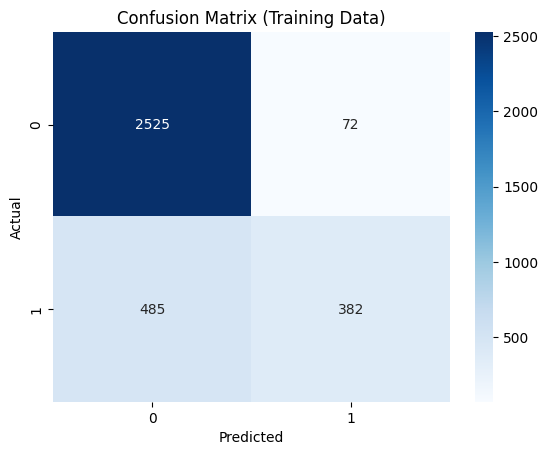

In [ ]:
y_train_pred = svm_model.predict(X_train)

# Classification report
print("Training Data:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training Data)')
plt.show()

**Predict On Test Data:**

Test Data:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1200
           1       0.35      0.33      0.34       200

    accuracy                           0.82      1400
   macro avg       0.62      0.61      0.62      1400
weighted avg       0.81      0.82      0.82      1400



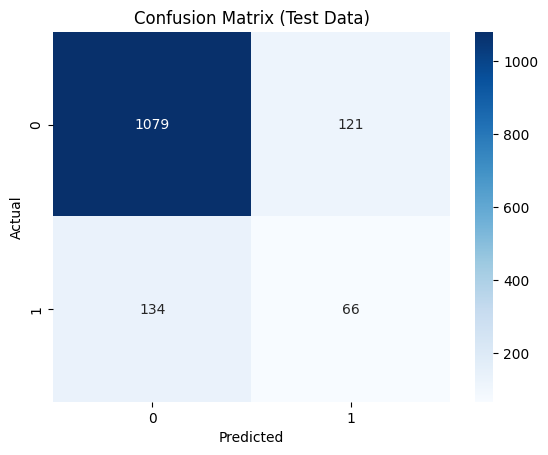

In [ ]:
y_test_pred = svm_model.predict(X_test)

# Classification report
print("Test Data:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.show()

**Investigate Correct And Incorrect Predictions:**

In [ ]:
# Extract correct and incorrect predictions
df_test['predicted'] = y_test_pred
df_test['correct'] = df_test['label'] == df_test['predicted']

correct_predictions = df_test[df_test['correct']]
incorrect_predictions = df_test[~df_test['correct']]

# Display some correct and incorrect predictions
print("\nSome Correct Predictions:")
print(correct_predictions[['Tweets_Cleaned', 'label', 'predicted']].head())

print("\nSome Incorrect Predictions:")
print(incorrect_predictions[['Tweets_Cleaned', 'label', 'predicted']].head())


Some Correct Predictions:
                                      Tweets_Cleaned  label  predicted
0  size toulouse team pack monstrous cant see wel...      0          0
1                                          pinball !      0          0
2  scottish government want people get booster sh...      1          1
5  there one fictional place could go christmas h...      0          0
6  mean great cause theyre new xmas music thats w...      0          0

Some Incorrect Predictions:
                                       Tweets_Cleaned  label  predicted
3   villainous pro tip change device name bluetoot...      0          1
4                                    would date men 🥺      0          1
9   sometimes lay bed think today day make life be...      1          0
10                      surprise ! kat PR queen 👑💕🌟👏🏻      0          1
13  wow chelsea bean beaten west ham day looking f...      0          1


**Check Specific Tweets:**



In [ ]:
tweet = "Biden is a great President like none other we have had"
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: Biden is a great President like none other we have had
Predicted: Non-Sarcastic


In [ ]:
tweet = "Max Verstappen is such a clean driver, he never makes dirty moves when racing."
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: Max Verstappen is such a clean driver, he never makes dirty moves when racing.
Predicted: Non-Sarcastic


In [ ]:
tweet = "I just can’t wait to spend time with my family over Christmas! I just love being the only single one and the many many questions asking when will I get a boyfriend 🙄"
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: I just can’t wait to spend time with my family over Christmas! I just love being the only single one and the many many questions asking when will I get a boyfriend 🙄
Predicted: Sarcastic


In [ ]:
tweet = "Well this is awesome news to wake up to!"
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: Well this is awesome news to wake up to!
Predicted: Sarcastic


In [ ]:
tweet = "So school have sent out a really helpful newsletter with all key dates and activities. So many fun things arranged for the children."
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: So school have sent out a really helpful newsletter with all key dates and activities. So many fun things arranged for the children.
Predicted: Sarcastic


In [ ]:
tweet = "I just love the smell of one million 😍"
tweet_cleaned = preprocess_text(tweet)
tweet_features = extract_features(pd.DataFrame({'Tweets_Cleaned': [tweet_cleaned]}), count_vectorizer)[0]
tweet_prediction = svm_model.predict(tweet_features)
print(f"Tweet: {tweet}")
print(f"Predicted: {'Sarcastic' if tweet_prediction == 1 else 'Non-Sarcastic'}")

Tweet: I just love the smell of one million 😍
Predicted: Non-Sarcastic
